In [1]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn.functional as F
import sys
from transformers import AutoTokenizer, AutoConfig, GPT2LMHeadModel
from transformers import AutoTokenizer, AutoConfig
# from interp_utils import get_model_from_checkpoint_path
sys.path.append("/datadrive/madhur/world-models/src")
# from training_utils import get_mlp_layers
import eval_utils
from utils import get_mlp_layers
from base_models import GPT2LMHeadModelCustom

from bertviz import model_view, head_view, model_view
torch.set_grad_enabled(False)

from matplotlib import pyplot as plt
from accelerate import Accelerator, DistributedType
import circuitsvis as cv



In [2]:
# model_path = "../model_3"
# model_path = "/datadrive/madhur/world-models/src/training_outputs/FromSingularity/1cd24e9d-9a34-4da0-987e-527619b49ec8"
# model_path = "/datadrive/madhur/world-models/src/training_outputs/c5de78a0-1b55-45e5-bd11-052e1f0e581d"
# model_path = "/datadrive/madhur/world-models/src/training_outputs/1cd24e9d-9a34-4da0-987e-527619b49ec8"; STEP_NUM=25 # person only ques no trans ATL L=2; H=1; E=128

# person only ques w/ trans ATL L=2; H=1; E=256
# model_path = "/datadrive/madhur/world-models/src/training_outputs/0cef3077-345d-4470-b554-d2988c42aef0"; STEP_NUM=40 # BS=512; LR=5e-5
# model_path = "/datadrive/madhur/world-models/src/training_outputs/25b844c7-9838-447a-b2b3-a351748b71a8"; STEP_NUM=40 # BS=512; LR=1e-4
# model_path = "/datadrive/madhur/world-models/src/training_outputs/723f3bf6-1c21-41c6-9702-f68d9ded720f"; STEP_NUM=35 # BS=128; LR=5e-5 -- 37 epochs done

# 3-digit addition model
# model_path = "/datadrive/madhur/addition_ckpt/checkpoint-59350"

# greater than
# model_path = "/datadrive/madhur/world-models/src/training_outputs/greater_than_TFprefix_L1_H1_E8/checkpoint-11870"
# model_path = "/datadrive/madhur/world-models/src/training_outputs/greater_than_TFprefix_L1_H2_E32/checkpoint-11870"
# model_path = "/datadrive/madhur/world-models/src/training_outputs/greater_than_TFprefix_L1_H4_E32/checkpoint-11870"
# model_path = "/datadrive/madhur/world-models/src/training_outputs/greater_than_TFprefix_L2_H4_E32/checkpoint-11870"

# 6-digit addition models
# w/ MLPs
# model_path = "/datadrive/madhur/world-models/src/training_outputs/smallest_w_MLPs_6-dig_add_plain_L2_H1_E128_mlps_all/checkpoint-73250"; mlp_all_or_none='all'; num_layers=2
# ----- model_path = "/datadrive/madhur/world-models/src/training_outputs/6-dig_add_plain_L2_H2_E128_mlps_all/checkpoint-73250"; mlp_all_or_none='all'; num_layers=2
model_path = "/datadrive/madhur/world-models/src/training_outputs/6-dig_add_reverse_L1_H1_E128_mlps_all/checkpoint-73250"; mlp_all_or_none='all'; num_layers=1

# w/o MLPs
# model_path = "/datadrive/madhur/world-models/src/training_outputs/smallest_w_MLPs_6-dig_add_plain_L4_H2_E256_mlps_none/checkpoint-73250"; mlp_all_or_none='none'; num_layers=4
# ----- model_path = "/datadrive/madhur/world-models/src/training_outputs/6-dig_add_plain_L4_H4_E256_mlps_none/checkpoint-73250"; mlp_all_or_none='none'; num_layers=4 # DNN1
# model_path = "/datadrive/madhur/world-models/src/training_outputs/6-dig_add_reverse_L4_H4_E256_mlps_none/checkpoint-73250"; mlp_all_or_none='none'; num_layers=4 # DNN1

# model_path = "/datadrive/madhur/world-models/src/training_outputs/3fb29362-e298-4565-b3e9-acf33061217b"

# model_path = "/datadrive/madhur/world-models/src/training_outputs/cbf01830-50d8-4739-bb86-39f6a8de0bb4" # no PE
# model_path = "/datadrive/madhur/world-models/src/training_outputs/0007e061-f46b-423e-b7b2-19f5479356f4" # no PE, no dropout
# model_path = "/datadrive/madhur/world-models/src/training_outputs/cbf01830-50d8-4739-bb86-39f6a8de0bb4" # no PE
# model_path  = "/datadrive/madhur/world-models/src/training_outputs/cc0f50da-c754-4a08-8269-ac0f2e31f3bf" # transactions; only person questions
# model_path  = "/datadrive/madhur/world-models/src/training_outputs/121f0d35-3b48-4955-9b48-a55b2eb9495b" # transactions; only boolean questions
# model_path  = "/datadrive/madhur/world-models/src/training_outputs/c06ae041-7813-46c7-968e-86c8c910619f" # transactions; only person and boolean questions


### Custom Tokenizers

In [3]:
class customTokenizerAddition6digit():
    def __init__(self,):
        self.bos_token = "B"
        self.eos_token = "E"
        self.pad_token = "P"
        self.bos_token_id = 12
        self.eos_token_id = 13
        self.pad_token_id = 14
        self.special_token_ids = [self.bos_token_id, self.eos_token_id, self.pad_token_id]
        
        self.vocab = {str(i): i for i in range(10)}
        self.vocab[self.bos_token] = self.bos_token_id
        self.vocab[self.eos_token] = self.eos_token_id
        self.vocab[self.pad_token] = self.pad_token_id
        self.vocab["+"] = 10
        self.vocab["="] = 11

        self.vocab_inv = {v: k for k, v in self.vocab.items()}
        self.padding_side = "right"

    def __call__(self, strings, **kwargs):
        # only used by hooked_model.to_tokens()
        if type(strings) == str:
            strings = [strings]
        ids = []
        max_len = max(map(lambda x: len(x), strings))
        for s in strings:
            ids.append( list(map(lambda x: self.vocab[x], s)) + [self.pad_token_id] * (max_len-len(s)) )

        return {"input_ids": torch.LongTensor(ids)}

    def convert_ids_to_tokens(self, ids, rm_special=False):
        if rm_special:
            return [self.vocab_inv[i] for i in ids if i not in self.special_token_ids]
        else:
            return list(map(lambda x: self.vocab_inv[x], ids))

    def __len__(self):
        return len(self.vocab)


class customTokenizerAddition(): # this if for 3-digit addition
    def __init__(self,):
        self.bos_token = "B"
        self.eos_token = "E"
        self.pad_token = "P"
        self.bos_token_id = 10
        self.eos_token_id = 13
        self.pad_token_id = 14
        self.special_token_ids = [self.bos_token_id, self.eos_token_id, self.pad_token_id]
        
        self.vocab = {str(i): i for i in range(10)}
        self.vocab[self.bos_token] = self.bos_token_id
        self.vocab[self.eos_token] = self.eos_token_id
        self.vocab[self.pad_token] = self.pad_token_id
        self.vocab["+"] = 11
        self.vocab["="] = 12

        self.vocab_inv = {v: k for k, v in self.vocab.items()}
        self.padding_side = "right"

    def __call__(self, strings, **kwargs):
        # only used by hooked_model.to_tokens()
        if type(strings) == str:
            strings = [strings]
        ids = []
        max_len = max(map(lambda x: len(x), strings))
        for s in strings:
            ids.append( list(map(lambda x: self.vocab[x], s)) + [self.pad_token_id] * (max_len-len(s)) )

        return {"input_ids": torch.LongTensor(ids)}

    def convert_ids_to_tokens(self, ids, rm_special=False):
        if rm_special:
            return [self.vocab_inv[i] for i in ids if i not in self.special_token_ids]
        else:
            return list(map(lambda x: self.vocab_inv[x], ids))

    def __len__(self):
        return len(self.vocab)
    

class customTokenizerGreaterThan():
    def __init__(self,):
        self.bos_token = "B"
        self.eos_token = "E"
        self.pad_token = "P"
        self.bos_token_id = 10
        self.eos_token_id = 11
        self.pad_token_id = 12
        self.special_token_ids = [self.bos_token_id, self.eos_token_id, self.pad_token_id]
        
        self.vocab = {str(i): i for i in range(10)}
        self.vocab[self.bos_token] = self.bos_token_id
        self.vocab[self.eos_token] = self.eos_token_id
        self.vocab[self.pad_token] = self.pad_token_id
        # self.vocab["+"] = 11
        # self.vocab["="] = 12
        self.vocab[">"] = 13
        self.vocab["T"] = 14
        self.vocab["F"] = 15

        self.vocab_inv = {v: k for k, v in self.vocab.items()}
        self.padding_side = "right"

    def __call__(self, strings, **kwargs):
        # only used by hooked_model.to_tokens()
        if type(strings) == str:
            strings = [strings]
        ids = []
        max_len = max(map(lambda x: len(x), strings))
        for s in strings:
            ids.append( list(map(lambda x: self.vocab[x], s)) + [self.pad_token_id] * (max_len-len(s)) )

        return {"input_ids": torch.LongTensor(ids)}

    def convert_ids_to_tokens(self, ids, rm_special=False):
        if rm_special:
            return [self.vocab_inv[i] for i in ids if i not in self.special_token_ids]
        else:
            return list(map(lambda x: self.vocab_inv[x], ids))

    def __len__(self):
        return len(self.vocab)

### Rest of the code

### Model loading and attention plotting (for most models)

In [7]:
# model = GPT2LMHeadModel.from_pretrained(model_path, output_attentions=True, output_hidden_states=True)
# model, config = eval_utils.get_model_from_checkpoint_path(model_path, step_num=STEP_NUM, accelerator = Accelerator(), args=None, \
#     step_or_epoch="epoch", mlp_layers=None, is_no_pos_encode=False, device='cpu', model_load_args={'output_attentions':True, 'output_hidden_states':True})

# model = GPT2LMHeadModel.from_pretrained(model_path)

model = GPT2LMHeadModel.from_pretrained(model_path, output_attentions=True, output_hidden_states=True)
# model.to('cuda:0')
model.eval()
# tokenizer = customTokenizerAddition()
tokenizer = customTokenizerGreaterThan()
# tokenizer = AutoTokenizer.from_pretrained(model_path)
print("model loaded")

model loaded


In [ ]:
# text = "P8 has O2, O15, O20. P7 has no objects. P8 gives O15 to P7. P8 gives O20 to P7. Who has object O2? Answer: P8."
# text = "P8 has O2, O15, O20. P7 has O16. P8 gives O15, O2, O20 to P7. P7 gives O16, O15, O20 to P8. Who has object O16? Answer: P8."
# text = "P1 has O2, O15, O20. P2 has O16. P3 gives O15, O2, O20 to P4. P5 gives O13, O15, O20 to P6. Who has object O16? Answer: P8."
# text = "P1 has O1, O2, O3. P2 has O7. P3 gives O4, O5, O6 to P4. P8 has O8, O9, O10. P5 gives O11, O12, O13 to P6. Who has object O8? Answer: P8."
# text = "P8 has O2. P7 has O17, O11. P6 has O15, O28. P7 gives O17 to P8. P8 gives O17 to P7. P8 gives O2 to P7. P7 gives O17 to P8. Who has object O2? Answer: P7."
# text = "P7 has O30, O26, O1. P1 has no objects. P9 has O21, O20, O12. P7 gives O30, O26 to P1. Who has object O21? Answer: P9."
# text = "P6 has O25, O13, O1. P9 has O23, O28. P7 has no objects. P9 gives O23, O28 to P7. P6 gives O25, O13 to P7. P6 gives O1 to P9. Who has object O1? Answer: P9."

# text = "P3 has O1, O8, O19. P2 has no objects. Who has object O1? Answer: P3."
# text = "has P3 objects no. P2 has O3, O17, O1. has P10 O11, O15, O5. Who has object ? O1 Answer: P2."
# text = "P3 has objects no. P2 has O1, O17, O3. has P10 O15, O11, O5. Who has object ? O1 Answer: P2."

# text = "P9 has O16. P3 has O12, O1, O27. P3 gives O12 to P9. P9 gives O16 to P3. Who has object O12? Answer: P9."
# text = "P9 has O16. P3 has O12, O1, O27. P3 gives O12 to P9. P9 gives O16 to P3. Does person P9 have object O16? Answer: No."

# text = "P3 has O21, O15, O11. P2 has O1, O17, O3. Who has object O1? Answer: P2."
# text="P3 has O1, O8, O19. P2 has O30. Who has object O1? Answer: P3."
# text = "P3 has O21. P2 has O1, O17, O3. P10 has O15, O11, O5. Who has O1 object? Answer: P2."
# text = "P3 has O21. P2 has O1, O17, O3. P10 has O15, O11, O5. Who O1 has object? Answer: P2."
# text = "P3 has O21. P2 has O1, O17, O3. P10 has O15, O11, O5. O1 Who has object? Answer: P2."
# text = "P3 has O21. P2 has O1, O17, O3. P10 has O15, O11, O5 O1. Who has object? Answer: P2."

# text = "has O21 P3. has P2 O3, O17, O1. has O15, P10 O5, O11. has Who object O5? Answer: P2."
# text = "P9 has O15, O14, O29. P6 has O24, O6, O20. P2 has no objects. Who has object O24? Answer: P6."
# text = "P9 has O15, O14, O29. P6 has O24, O6, O20. P2 has no objects. Who has object O21? Answer: P6."


# text = "403+288=691"
text = "234503+671249=905752"
# text = "T101>110"
# text = tokenizer.bos_token + ' ' + text + ' ' + tokenizer.eos_token
text = tokenizer.bos_token + text + tokenizer.eos_token
tokenized_data = tokenizer(text)

tokens = tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"][0].tolist())

In [6]:
output = model(torch.tensor(tokenized_data["input_ids"]).unsqueeze(0))
head_view(output.attentions, tokens)

generated_output = model.generate(tokenized_data["input_ids"][:,:6].clone().detach(), max_length=14, do_sample=False)
generated_tokens = tokenizer.convert_ids_to_tokens(generated_output[0].tolist())
print("generated:", "".join(generated_tokens))

# need to decode, since the prediction must be looped back into the model. The following doesn't work.
# pred4 = output.logits[0,0,-6].argmax().item()
# pred3 = output.logits[0,0,-5].argmax().item()
# pred2 = output.logits[0,0,-4].argmax().item()
# pred1 = output.logits[0,0,-3].argmax().item()

# pred_list=[pred4, pred3, pred2, pred1]
# print("prediction:", "".join(tokenizer.convert_ids_to_tokens(pred_list)))


NameError: name 'tokenized_data' is not defined

### Model loading and attention plotting (for 6-digit addition models)

In [8]:
tokenizer = customTokenizerAddition6digit()
mlp_layers = get_mlp_layers(mlp_all_or_none, num_layers)
custom_args = {
    "is_pos_encode": True, 
    "only_pos_at_pos_index": None,
    "pos_enc_type": "learnable",
    "mlp_layers": mlp_layers,
    "is_resid_conn": True
}
model = GPT2LMHeadModelCustom.from_pretrained(model_path, custom_args, output_attentions=True, output_hidden_states=True)
model.eval()
print("model loaded")

model loaded


In [18]:

# text = "403+288=691"
# text = "234503+671249=905752"
# text = "234503+671249=8067421"
text = "999999+999999=8999991"

# text = "876548+671249=8067421"
# text = "123421+234152=357573"
# text = "434583+675649=1110232"
# text = "333333+666666=999999"
# text = "T101>110"
# text = tokenizer.bos_token + ' ' + text + ' ' + tokenizer.eos_token
text = tokenizer.bos_token + text + tokenizer.eos_token
tokenized_data = tokenizer(text)

tokens = tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"][0].tolist())

In [19]:
tokenized_data

{'input_ids': tensor([[12,  9,  9,  9,  9,  9,  9, 10,  9,  9,  9,  9,  9,  9, 11,  8,  9,  9,
           9,  9,  9,  1, 13]])}

In [20]:
output = model(tokenized_data["input_ids"])
head_view(output.attentions, tokens)

generated_output = model.generate(tokenized_data["input_ids"][:,:15].clone().detach(), max_new_tokens=10, do_sample=False)
generated_tokens = tokenizer.convert_ids_to_tokens(generated_output[0].tolist())
print("generated:", "".join(generated_tokens))


<IPython.core.display.Javascript object>

generated: B999999+999999=8999991E


### Visualization using circuitsvis

In [9]:
layer_idx = 0
# weighted_by_v_norm = False

attention_pattern = output.attentions[layer_idx][0] # batch_size=1 so index by [0]

# if weighted_by_v_norm:
#     v_vector = cache["v", layer_idx, "attn"]
#     v_norm = torch.linalg.vector_norm(v_vector, dim=-1)
#     attention_pattern = attention_pattern * v_norm.transpose(0, 1).unsqueeze(1)
#     attention_pattern /= 10

# print(f"\nLayer {layer_idx} Head Attention Patterns:")
cv.attention.attention_patterns(tokens=generated_tokens, attention=attention_pattern)

### Generation bands for greater than, i.e. NUM2 for all possible NUM1s

generated: [110, 112, 112, 112, 112, 110, 110, 100, 100, 100, 110, 112, 112, 112, 112, 112, 110, 110, 110, 100, 110, 112, 112, 112, 112, 112, 110, 110, 100, 100, 110, 112, 112, 112, 112, 112, 110, 100, 100, 100, 110, 112, 112, 112, 112, 112, 100, 100, 100, 100, 110, 112, 112, 112, 112, 112, 100, 100, 100, 100, 110, 112, 112, 112, 112, 100, 100, 100, 100, 100, 100, 112, 112, 112, 100, 100, 100, 100, 100, 100, 100, 112, 112, 100, 100, 100, 100, 100, 100, 100, 100, 112, 100, 100, 100, 100, 100, 100, 100, 100, 100, 112, 112, 100, 100, 100, 100, 100, 100, 100, 110, 112, 112, 112, 112, 112, 100, 100, 100, 100, 110, 112, 112, 112, 112, 100, 100, 100, 100, 100, 100, 112, 112, 122, 100, 100, 100, 100, 100, 100, 100, 112, 122, 122, 100, 100, 100, 100, 100, 100, 100, 112, 112, 100, 100, 100, 100, 100, 100, 100, 100, 112, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100

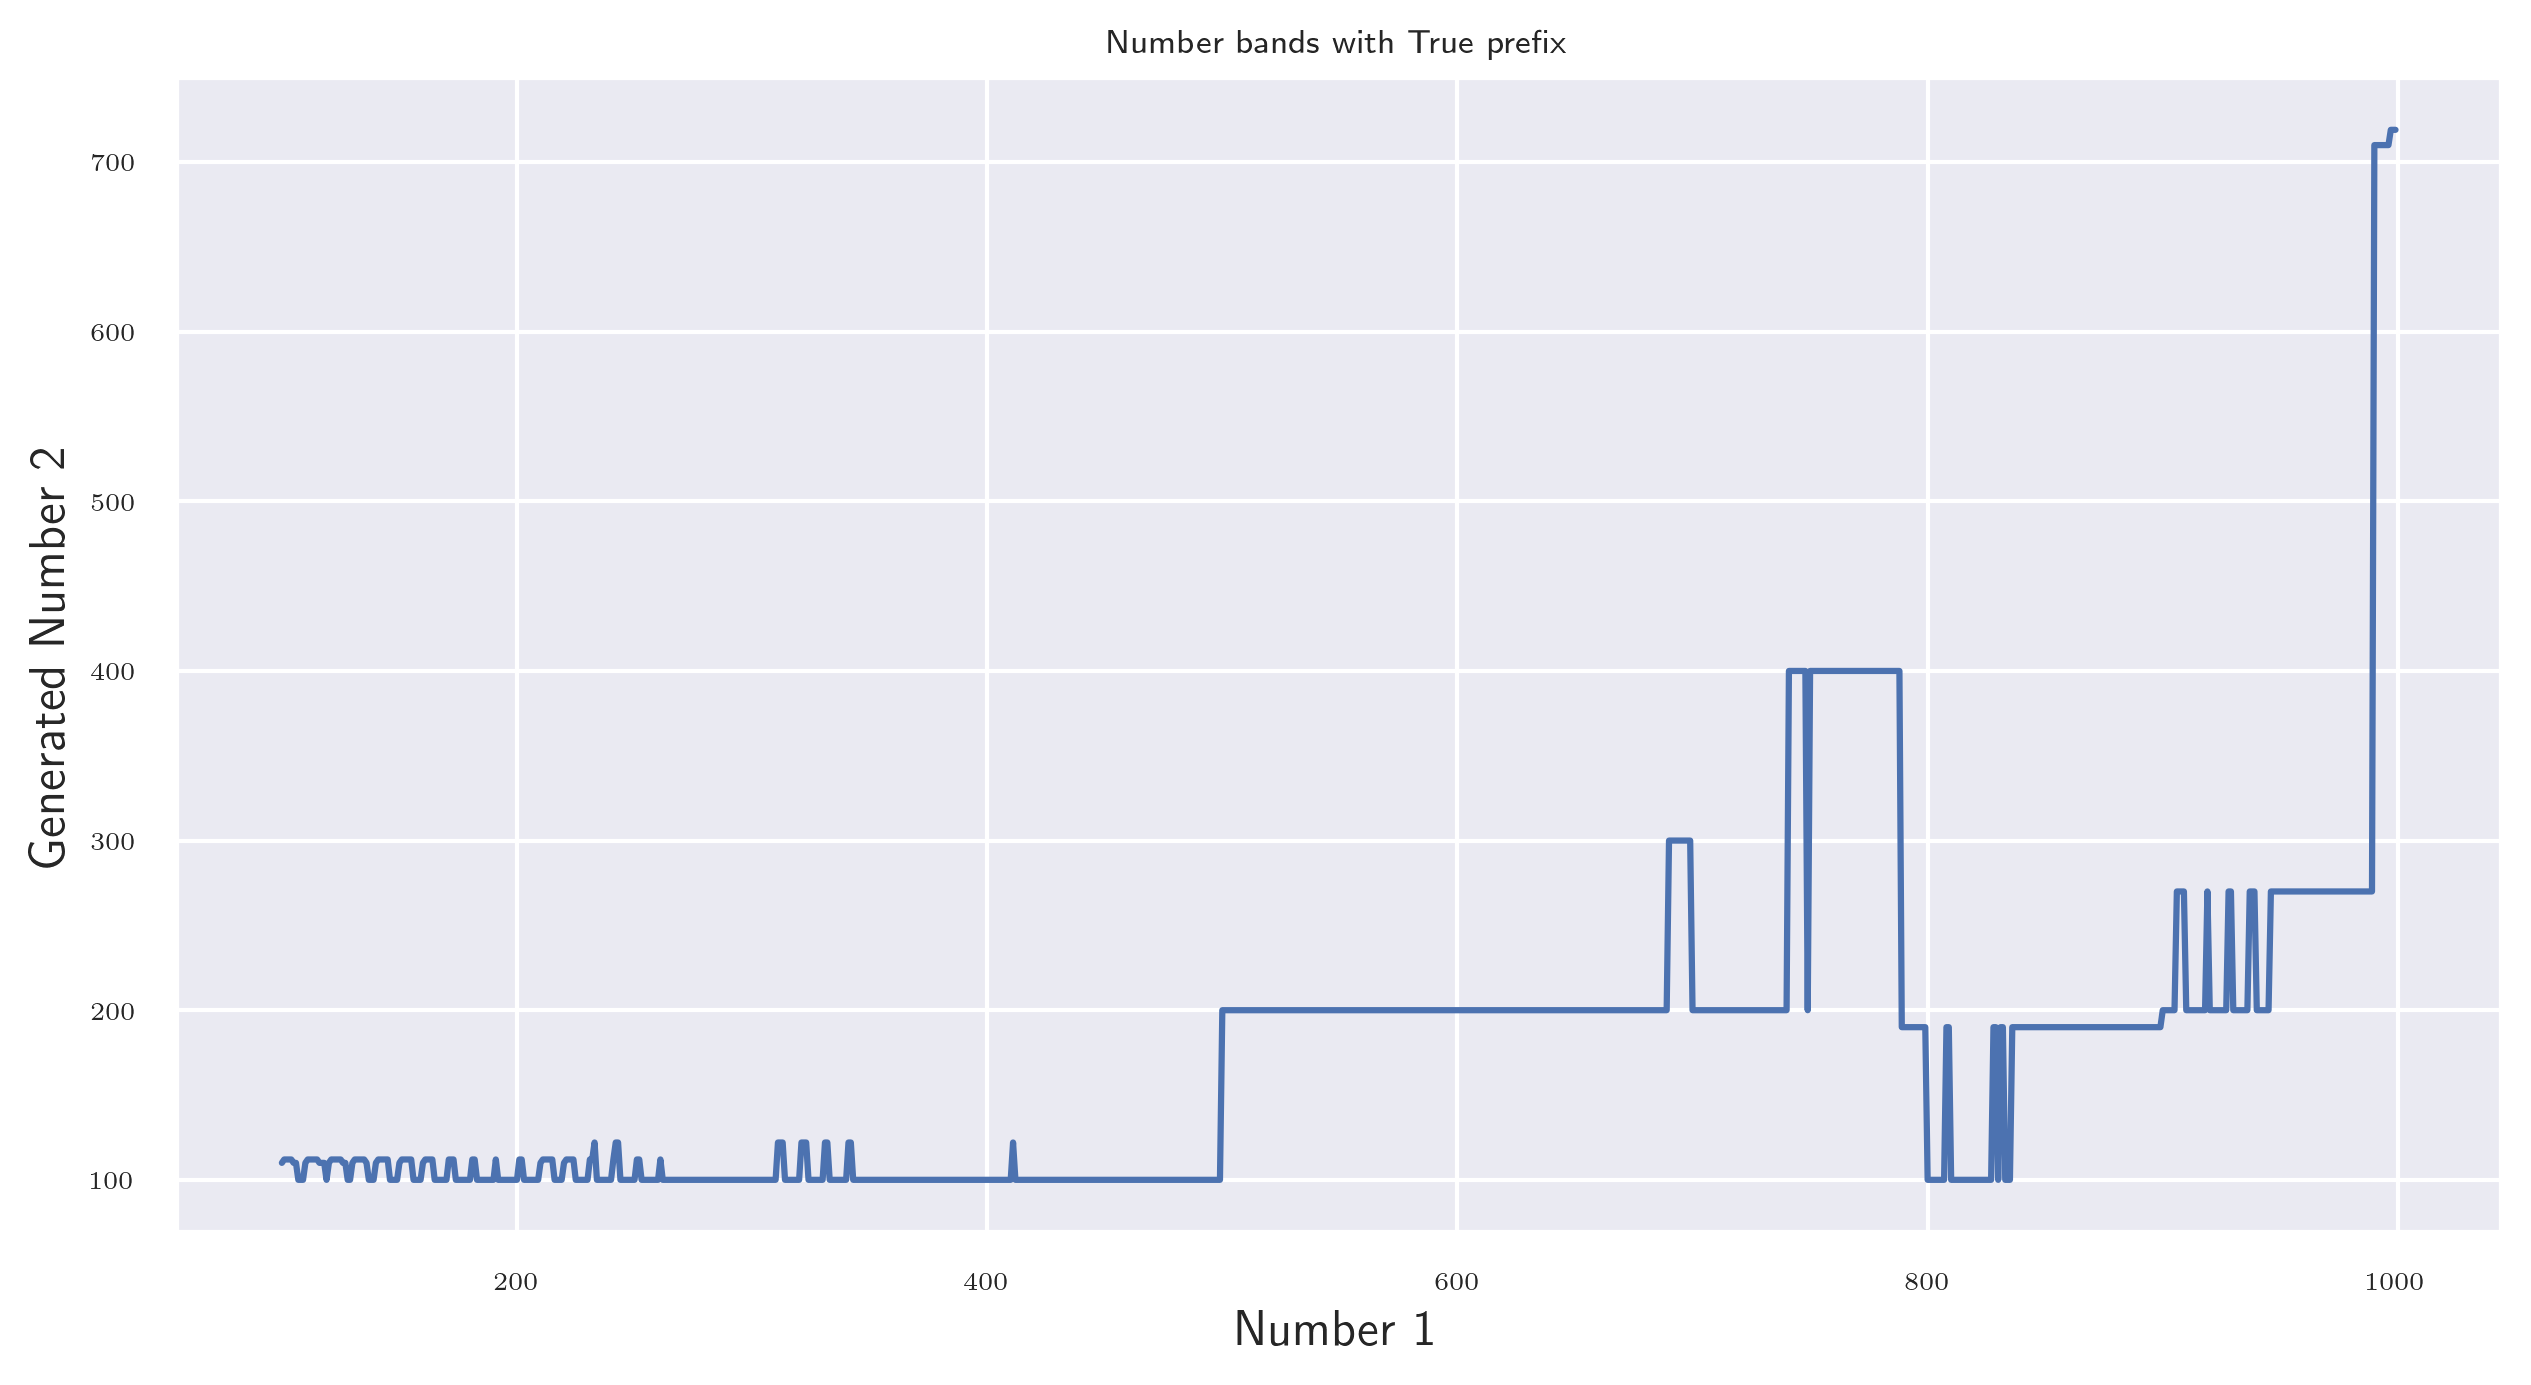

In [7]:
# Generation bands for greater than

prefix="True"

NUM1_range = list(range(100, 1000))
NUM1_nums = []
for NUM1 in NUM1_range:
    text = f"{prefix[0]}{NUM1}>100" # doesn't matter what the second number is
    text = tokenizer.bos_token + text + tokenizer.eos_token
    NUM1_nums.append(text)
    
tokenized_data = tokenizer(NUM1_nums)

generated_output = model.generate(tokenized_data["input_ids"][:,:6].clone().detach(), max_length=14, do_sample=False)
generated_tokens = [tokenizer.convert_ids_to_tokens(generated_output[i].tolist()) for i in range(len(NUM1_nums))]
y = [int("".join(toks)[6:-1]) for toks in generated_tokens]
print("generated:", y)

x = NUM1_range

# plot a lineplot of x vs y with (10, 5) figure size, title "Number bands with True prefix", x label "Number 1", y label "Generated Number 2"
plt.figure(figsize=(10, 5))
plt.title(f"Number bands with {prefix} prefix")
plt.xlabel("Number 1")
plt.ylabel("Generated Number 2")
plt.plot(x, y)


### Distribution of NUM2 for all NUM1s

In [6]:
def make_initial_prompt(prefix, num1):
    text = f"{prefix}{str(num1)}>"
    text = tokenizer.bos_token + text
    return text

def get_LM_output(text):
    tokenized_data = tokenizer(text)
    print(tokenized_data)
    output = model(torch.tensor(tokenized_data["input_ids"]).unsqueeze(0))
    return output

def get_LM_output_distribution(text):
    output = get_LM_output(text)
    return F.softmax(output.logits[0,0,-1], dim=-1) # a vocab size vector



In [20]:
import random

prefix = "F"
num_digits = 3

random.seed(0)
NUM1_range = random.sample(range(100, 1000), 10)
NUM1_nums = list(NUM1_range) + list(range(100, 1000, 100))

dig_dist_NUMS = {} # dig_dist at index i is the distribution of the ith digit where MSD is num_digits-1 and LSD is 0
print(NUM1_nums)
for NUM1 in NUM1_nums:
    dig_dist = {} # for each NUM1 we will have a distribution for each digit
    text = make_initial_prompt(prefix, NUM1) # make the initial prompt
    tokenized_data = tokenizer(text)
    output_dist = get_LM_output_distribution(text) # this is the distribution of the first digit, i.e. MSD
    dig_dist[num_digits-1] = {str(i):x for i,x in enumerate(output_dist[:10])} # set the distribution for MSD
    # dig_dist[2] = {0: 0.4, 1: 0.6, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}

    # To get the distribution of each subsequent digit, we consition on every possible prefix and obtain the distribution
    for dig_idx in range(num_digits-1-1, -1, -1): # iterate from digit next to MSD to LSD, i,e 1 to 0 (inclusive) for 3-digit numbers
        print("getting probs for digit", dig_idx)
        dig_dist[dig_idx] = {}
        for digit_prefix in dig_dist[dig_idx+1].keys(): # take the keys of the previous digit's distribution which are all the previous digit prefixes
            print("getting prefix", digit_prefix)
            prefix_prob = dig_dist[dig_idx+1][digit_prefix] # get the distribution of the previous digit
            curr_text = text + digit_prefix # T100>7
            output_dist = get_LM_output_distribution(curr_text)
            dig_dist[dig_idx].update({(digit_prefix+str(i)): (x*prefix_prob) for i,x in enumerate(output_dist[:10])})
            # for dig_idx=1, this adds 00, 01, 02, ..., 10, 11, 12, ...., 97, 98, 99 to the distribution
            # for dig_idx=0, this adds 000, 001, 002, ..., 100, 101, 102, ...., 997, 998, 999 to the distribution
    
    dig_dist_NUMS[NUM1] = dig_dist
    print(f"Distribution for {NUM1} is: \n {dig_dist[0]}")


[964, 494, 876, 530, 141, 365, 623, 597, 514, 902, 100, 200, 300, 400, 500, 600, 700, 800, 900]
{'input_ids': tensor([[10, 15,  9,  6,  4, 13]])}
getting probs for digit 1
getting prefix 0
{'input_ids': tensor([[10, 15,  9,  6,  4, 13,  0]])}
getting prefix 1
{'input_ids': tensor([[10, 15,  9,  6,  4, 13,  1]])}
getting prefix 2
{'input_ids': tensor([[10, 15,  9,  6,  4, 13,  2]])}
getting prefix 3
{'input_ids': tensor([[10, 15,  9,  6,  4, 13,  3]])}
getting prefix 4
{'input_ids': tensor([[10, 15,  9,  6,  4, 13,  4]])}
getting prefix 5
{'input_ids': tensor([[10, 15,  9,  6,  4, 13,  5]])}
getting prefix 6
{'input_ids': tensor([[10, 15,  9,  6,  4, 13,  6]])}
getting prefix 7
{'input_ids': tensor([[10, 15,  9,  6,  4, 13,  7]])}
getting prefix 8
{'input_ids': tensor([[10, 15,  9,  6,  4, 13,  8]])}
getting prefix 9
{'input_ids': tensor([[10, 15,  9,  6,  4, 13,  9]])}
getting probs for digit 0
getting prefix 00
{'input_ids': tensor([[10, 15,  9,  6,  4, 13,  0,  0]])}
getting prefix 0

/tmp/ipykernel_754227/1309355394.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(tokenized_data["input_ids"]).unsqueeze(0))


Distribution for 964 is: 
 {'000': tensor(1.4716e-05), '001': tensor(1.4919e-05), '002': tensor(1.5318e-05), '003': tensor(1.4900e-05), '004': tensor(1.4476e-05), '005': tensor(1.4835e-05), '006': tensor(1.4548e-05), '007': tensor(1.4633e-05), '008': tensor(1.4555e-05), '009': tensor(1.4224e-05), '010': tensor(1.4931e-05), '011': tensor(1.4923e-05), '012': tensor(1.5213e-05), '013': tensor(1.4838e-05), '014': tensor(1.4665e-05), '015': tensor(1.5353e-05), '016': tensor(1.5245e-05), '017': tensor(1.5203e-05), '018': tensor(1.5005e-05), '019': tensor(1.4869e-05), '020': tensor(1.6337e-05), '021': tensor(1.6045e-05), '022': tensor(1.6788e-05), '023': tensor(1.6357e-05), '024': tensor(1.5951e-05), '025': tensor(1.6432e-05), '026': tensor(1.6261e-05), '027': tensor(1.6319e-05), '028': tensor(1.6287e-05), '029': tensor(1.6287e-05), '030': tensor(1.6069e-05), '031': tensor(1.5633e-05), '032': tensor(1.6452e-05), '033': tensor(1.6396e-05), '034': tensor(1.6049e-05), '035': tensor(1.6285e-05), 

### Other checks

In [6]:
# Distribution of digits at each place
for NUM1 in NUM1_nums:
    print("For number", NUM1)
    # MSD
    print(f"MSD {dig_dist_NUMS[NUM1][2]}")
          
    # 2nd digit
    full_dist=dig_dist_NUMS[NUM1][1]
    temp_dist={}
    for i in range(10):
        temp_dist[str(i)]=sum([v for k,v in full_dist.items() if k[-1]==str(i)])/10
    print(f"Next to MSD {temp_dist})")

    # LSD
    full_dist=dig_dist_NUMS[NUM1][0]
    temp_dist={}
    for i in range(10):
        temp_dist[str(i)]=sum([v for k,v in full_dist.items() if k[-1]==str(i)])/100
    print(f"LSD {temp_dist})")






NameError: name 'NUM1_nums' is not defined

In [16]:


for NUM1 in NUM1_nums:
    print("For number", NUM1)
    # MSD
    print(f"MSD {dig_dist_NUMS[NUM1][2]}")
          
    # 2nd digit
    full_dist=dig_dist_NUMS[NUM1][1]
    print(f"Next to MSD {full_dist})")

    # LSD
    full_dist=dig_dist_NUMS[NUM1][0]
    print(f"LSD {full_dist})")

    print("\n\n")

For number 964
MSD {'0': tensor(0.0025), '1': tensor(0.0724), '2': tensor(0.1029), '3': tensor(0.1261), '4': tensor(0.1423), '5': tensor(0.1478), '6': tensor(0.1376), '7': tensor(0.1191), '8': tensor(0.0906), '9': tensor(0.0582)}
Next to MSD {'00': tensor(0.1186), '01': tensor(0.0957), '02': tensor(0.0965), '03': tensor(0.0954), '04': tensor(0.0947), '05': tensor(0.0962), '06': tensor(0.0962), '07': tensor(0.0981), '08': tensor(0.1015), '09': tensor(0.1062), '10': tensor(0.0996), '11': tensor(0.0967), '12': tensor(0.0995), '13': tensor(0.0994), '14': tensor(0.0994), '15': tensor(0.1010), '16': tensor(0.1003), '17': tensor(0.1005), '18': tensor(0.1013), '19': tensor(0.1017), '20': tensor(0.1009), '21': tensor(0.0963), '22': tensor(0.0992), '23': tensor(0.0992), '24': tensor(0.0993), '25': tensor(0.1009), '26': tensor(0.1002), '27': tensor(0.1005), '28': tensor(0.1012), '29': tensor(0.1015), '30': tensor(0.1023), '31': tensor(0.0971), '32': tensor(0.0997), '33': tensor(0.0995), '34': ten

LSD {'000': tensor(0.1193), '001': tensor(0.0961), '002': tensor(0.0967), '003': tensor(0.0953), '004': tensor(0.0945), '005': tensor(0.0960), '006': tensor(0.0960), '007': tensor(0.0979), '008': tensor(0.1012), '009': tensor(0.1061), '010': tensor(0.0993), '011': tensor(0.1013), '012': tensor(0.1026), '013': tensor(0.1012), '014': tensor(0.1002), '015': tensor(0.1011), '016': tensor(0.0994), '017': tensor(0.0987), '018': tensor(0.0982), '019': tensor(0.0973), '020': tensor(0.0997), '021': tensor(0.0987), '022': tensor(0.1009), '023': tensor(0.1003), '024': tensor(0.0999), '025': tensor(0.1012), '026': tensor(0.1000), '027': tensor(0.0997), '028': tensor(0.0997), '029': tensor(0.0993), '030': tensor(0.1002), '031': tensor(0.0975), '032': tensor(0.1001), '033': tensor(0.0998), '034': tensor(0.0997), '035': tensor(0.1012), '036': tensor(0.1002), '037': tensor(0.1001), '038': tensor(0.1003), '039': tensor(0.1001), '040': tensor(0.1002), '041': tensor(0.0970), '042': tensor(0.0997), '043':

### Main plotter

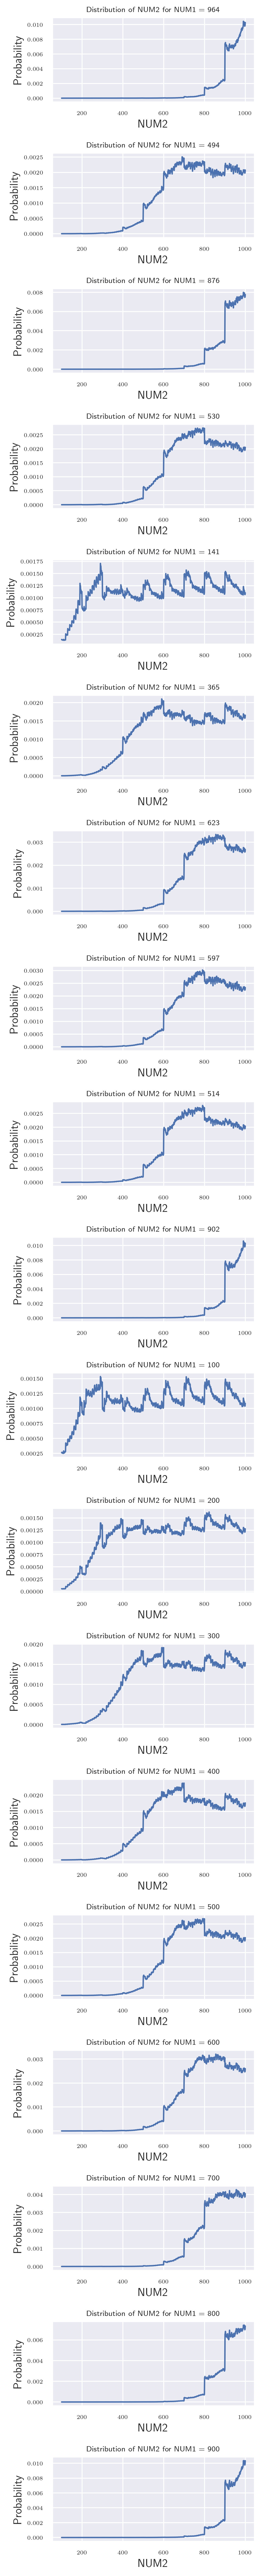

In [21]:
# plot a lineplot of x vs y with (10, 5) figure size, title "Number bands with True prefix", x label "Number 1", y label "Generated Number 2"


# for NUM1 in NUM1_nums:
#     plt.figure(figsize=(4, 2))
#     dist = dig_dist_NUMS[NUM1][0]
#     plt.title(f"Distribution of NUM2 for NUM1 = {NUM1}")
#     plt.xlabel("NUM2")
#     plt.ylabel("Probability")
#     x=list(range(100, 1000))
#     y = [dist[str(k)] for k in x]
#     plt.plot(x, y)
#     plt.show()

fig, axs = plt.subplots(len(NUM1_nums), 1, figsize=(4, 2*len(NUM1_nums)))

for ax, NUM1 in zip(axs, NUM1_nums):
    dist = dig_dist_NUMS[NUM1][0]
    ax.set_title(f"Distribution of NUM2 for NUM1 = {NUM1}")
    ax.set_xlabel("NUM2")
    ax.set_ylabel("Probability")
    x=list(range(100, 1000))
    y = [dist[str(k)] for k in x]
    ax.plot(x, y)

plt.tight_layout()
plt.show()

In [ ]:
random.choice(range(100, 1000), size=10)) + range(100, 1000, 100)




In [19]:
output.logits.shape

torch.Size([1, 1, 13, 15])

In [23]:
output.attentions[1].shape


torch.Size([1, 2, 35, 35])

In [11]:
def printneat(A: list):
    for x in A:
        print(f"{x[0]} --> {x[1]}")

In [12]:
def id_to_token_custom(id_list: list):
    token_list = tokenizer.convert_ids_to_tokens(id_list)
    token_list = ["EOS" if x == "<|endoftext|>" else x for x in token_list]
    token_list = ["BOS" if x == "<|startoftext|>" else x for x in token_list]
    return token_list

In [37]:
# ind=28
sent_len = output.attentions[0].shape[2]
lyr=0
head=1
for i in range(sent_len):
    print(f"Attention from token '{id_to_token_custom([tokenized_data['input_ids'][i]])[0]}' to all other tokens")
    printneat(list(zip(id_to_token_custom(tokenized_data['input_ids']), [round(x.item(),3) for x in output.attentions[lyr][0, head, i]  ])))
    print("\n\n")

Attention from token 'BOS' to all other tokens
BOS --> 1.0
P9 --> 0.0
has --> 0.0
O16 --> 0.0
. --> 0.0
P3 --> 0.0
has --> 0.0
O12 --> 0.0
, --> 0.0
O1 --> 0.0
, --> 0.0
O27 --> 0.0
. --> 0.0
P3 --> 0.0
gives --> 0.0
O12 --> 0.0
to --> 0.0
P9 --> 0.0
. --> 0.0
P9 --> 0.0
gives --> 0.0
O16 --> 0.0
to --> 0.0
P3 --> 0.0
. --> 0.0
Does --> 0.0
person --> 0.0
P9 --> 0.0
have --> 0.0
object --> 0.0
O16 --> 0.0
? --> 0.0
Answer --> 0.0
: --> 0.0
No --> 0.0
. --> 0.0
EOS --> 0.0



Attention from token 'P9' to all other tokens
BOS --> 0.968
P9 --> 0.032
has --> 0.0
O16 --> 0.0
. --> 0.0
P3 --> 0.0
has --> 0.0
O12 --> 0.0
, --> 0.0
O1 --> 0.0
, --> 0.0
O27 --> 0.0
. --> 0.0
P3 --> 0.0
gives --> 0.0
O12 --> 0.0
to --> 0.0
P9 --> 0.0
. --> 0.0
P9 --> 0.0
gives --> 0.0
O16 --> 0.0
to --> 0.0
P3 --> 0.0
. --> 0.0
Does --> 0.0
person --> 0.0
P9 --> 0.0
have --> 0.0
object --> 0.0
O16 --> 0.0
? --> 0.0
Answer --> 0.0
: --> 0.0
No --> 0.0
. --> 0.0
EOS --> 0.0



Attention from token 'has' to all oth

In [125]:
output.attentions[0][0, 0, 28]
to

NameError: name 'to' is not defined

In [93]:
tokenized_data

{'input_ids': [1, 14, 5, 40, 4, 15, 5, 26, 6, 43, 6, 27, 4, 18, 5, 28, 6, 35, 6, 53, 4, 10, 5, 11, 53, 8, 9, 7, 15, 4, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [16]:
import os
model_load_args={}
config = AutoConfig.from_pretrained(os.path.join(model_path, "config.json"), )

In [87]:
output.attentions[0][0, 0, 28]


tensor([0.0307, 0.0108, 0.0080, 0.0155, 0.0052, 0.0066, 0.0080, 0.0137, 0.0070,
        0.0149, 0.0070, 0.0155, 0.0052, 0.0107, 0.0080, 0.0151, 0.0070, 0.0165,
        0.0070, 0.0154, 0.0052, 0.2410, 0.0080, 0.1750, 0.0154, 0.0706, 0.1868,
        0.0632, 0.0066, 0.0000, 0.0000])

In [47]:
output.keys()

odict_keys(['logits', 'past_key_values', 'hidden_states', 'attentions'])

In [126]:
output.logits[0, -4]

tensor([-1.9940e-20, -7.1160e-20, -9.8156e-04, -5.4450e-21,  2.8906e-03,
         1.6086e-03, -5.3108e-03, -9.0959e-04, -3.5588e-04,  8.1783e-04,
         2.9112e-03, -9.3722e-04,  1.2760e-03,  7.3061e-04,  6.3377e-02,
         1.0219e+00, -6.9852e-03, -4.9743e-03, -9.2136e-03, -4.3654e-03,
        -4.3699e-03, -1.9597e-02, -1.6038e-02, -3.9332e-03, -2.1184e-03,
        -2.5040e-03,  9.6698e-03, -9.6843e-04,  7.9158e-04, -4.5943e-04,
         1.7483e-04, -2.8708e-03, -1.9997e-03, -2.3815e-03, -1.7304e-03,
        -8.1313e-04, -1.0500e-04, -1.3534e-03, -1.0073e-03, -4.1920e-04,
        -1.3432e-05, -1.1793e-03, -1.1306e-03, -2.2075e-04, -1.4696e-03,
        -9.2369e-04, -1.6329e-03, -1.4093e-03,  7.5302e-04, -3.6104e-04,
        -1.0771e-03, -7.5497e-04, -7.1652e-04,  6.5976e-04])

In [68]:
save_logits = output.logits

In [71]:
save_logits_2 = output.logits


In [72]:
save_logits[0, -4]

tensor([ 4.6196e-08, -6.4366e-06, -9.7719e-05,  6.5509e-07,  1.1804e-03,
         4.9723e-06, -3.8625e-06,  1.2302e-05,  6.5792e-06, -6.3470e-07,
         5.3913e-06,  1.9992e-06,  1.1634e-06, -6.7298e-06,  3.2615e-01,
         3.2142e-01, -3.9194e-03,  1.9756e-04,  3.5324e-01,  1.5087e-03,
         9.1236e-04,  1.7693e-03, -1.1016e-03,  4.1423e-04,  8.4553e-06,
         1.9087e-06,  2.1958e-07, -4.8861e-06,  2.2534e-06, -7.7834e-07,
         2.5698e-06,  8.4716e-06,  3.5903e-06, -1.1313e-05, -3.9548e-06,
         9.6983e-06, -4.1706e-07, -6.7335e-06, -4.8230e-06, -4.1228e-06,
        -3.2548e-06,  4.7712e-06,  5.3671e-06, -5.1722e-06,  3.3596e-06,
         2.3420e-06, -5.4210e-06, -5.5897e-06,  5.2494e-06,  4.3840e-06,
        -1.8534e-06,  8.8052e-06, -2.7101e-06, -5.6266e-06])

In [73]:
save_logits_2[0, -4]

tensor([ 9.6855e-08, -8.6064e-06, -8.4208e-05,  8.3661e-07,  1.1785e-03,
         6.6463e-06, -5.1538e-06,  1.6524e-05,  8.8210e-06, -8.0725e-07,
         7.2098e-06,  2.6794e-06,  1.5712e-06, -9.0226e-06,  3.2165e-01,
         3.2046e-01, -2.4824e-03,  7.7001e-04,  3.5591e-01,  1.8150e-03,
         9.1607e-04,  1.9347e-03, -6.4316e-04,  5.6503e-04,  1.1341e-05,
         2.4991e-06,  3.2020e-07, -6.5324e-06,  3.0116e-06, -1.0015e-06,
         3.4183e-06,  1.1383e-05,  4.7955e-06, -1.5196e-05, -5.2777e-06,
         1.3041e-05, -5.8776e-07, -9.0305e-06, -6.4490e-06, -5.5079e-06,
        -4.3452e-06,  6.3630e-06,  7.1817e-06, -6.9024e-06,  4.4710e-06,
         3.1331e-06, -7.2473e-06, -7.4761e-06,  7.0217e-06,  5.8585e-06,
        -2.4264e-06,  1.1815e-05, -3.6145e-06, -7.5265e-06])

In [79]:
model.state_dict().keys()

odict_keys(['transformer.wte.weight', 'transformer.h.0.ln_1.weight', 'transformer.h.0.ln_1.bias', 'transformer.h.0.attn.c_attn.weight', 'transformer.h.0.attn.c_attn.bias', 'transformer.h.0.attn.c_proj.weight', 'transformer.h.0.attn.c_proj.bias', 'transformer.h.0.ln_2.weight', 'transformer.h.0.ln_2.bias', 'transformer.h.0.mlp.c_fc.weight', 'transformer.h.0.mlp.c_fc.bias', 'transformer.h.0.mlp.c_proj.weight', 'transformer.h.0.mlp.c_proj.bias', 'transformer.h.1.ln_1.weight', 'transformer.h.1.ln_1.bias', 'transformer.h.1.attn.c_attn.weight', 'transformer.h.1.attn.c_attn.bias', 'transformer.h.1.attn.c_proj.weight', 'transformer.h.1.attn.c_proj.bias', 'transformer.h.1.ln_2.weight', 'transformer.h.1.ln_2.bias', 'transformer.h.1.mlp.c_fc.weight', 'transformer.h.1.mlp.c_fc.bias', 'transformer.h.1.mlp.c_proj.weight', 'transformer.h.1.mlp.c_proj.bias', 'transformer.ln_f.weight', 'transformer.ln_f.bias', 'lm_head.weight'])

False

## T-SNE Analysis

In [136]:
E = model.state_dict()['transformer.wte.weight']

In [132]:
# print(model.state_dict()['transformer.wte.weight'].shape)
import json

with open("/datadrive/madhur/world-models/src/tokenizer_local/wm_tokenizer_simpl_no_trans_only_person_ques/tokenizer.json") as f:
    data = json.load(f)

# data["model"]["vocab"]


{'<|UNK|>': 0,
 '<|startoftext|>': 1,
 '<|endoftext|>': 2,
 '<|PAD|>': 3,
 '.': 4,
 'has': 5,
 ',': 6,
 ':': 7,
 '?': 8,
 'Answer': 9,
 'Who': 10,
 'object': 11,
 'no': 12,
 'objects': 13,
 'P3': 14,
 'P2': 15,
 'P5': 16,
 'P8': 17,
 'P10': 18,
 'P1': 19,
 'P7': 20,
 'P6': 21,
 'P4': 22,
 'P9': 23,
 'O12': 24,
 'O20': 25,
 'O1': 26,
 'O3': 27,
 'O15': 28,
 'O8': 29,
 'O28': 30,
 'O14': 31,
 'O10': 32,
 'O27': 33,
 'O6': 34,
 'O11': 35,
 'O4': 36,
 'O7': 37,
 'O22': 38,
 'O2': 39,
 'O21': 40,
 'O24': 41,
 'O29': 42,
 'O17': 43,
 'O18': 44,
 'O30': 45,
 'O13': 46,
 'O23': 47,
 'O25': 48,
 'O26': 49,
 'O19': 50,
 'O16': 51,
 'O9': 52,
 'O5': 53}

In [134]:
inverse_dict = {v:k for k,v in data["model"]["vocab"].items()}
inverse_dict

{0: '<|UNK|>',
 1: '<|startoftext|>',
 2: '<|endoftext|>',
 3: '<|PAD|>',
 4: '.',
 5: 'has',
 6: ',',
 7: ':',
 8: '?',
 9: 'Answer',
 10: 'Who',
 11: 'object',
 12: 'no',
 13: 'objects',
 14: 'P3',
 15: 'P2',
 16: 'P5',
 17: 'P8',
 18: 'P10',
 19: 'P1',
 20: 'P7',
 21: 'P6',
 22: 'P4',
 23: 'P9',
 24: 'O12',
 25: 'O20',
 26: 'O1',
 27: 'O3',
 28: 'O15',
 29: 'O8',
 30: 'O28',
 31: 'O14',
 32: 'O10',
 33: 'O27',
 34: 'O6',
 35: 'O11',
 36: 'O4',
 37: 'O7',
 38: 'O22',
 39: 'O2',
 40: 'O21',
 41: 'O24',
 42: 'O29',
 43: 'O17',
 44: 'O18',
 45: 'O30',
 46: 'O13',
 47: 'O23',
 48: 'O25',
 49: 'O26',
 50: 'O19',
 51: 'O16',
 52: 'O9',
 53: 'O5'}

In [145]:
tokenNamesList = list(inverse_dict.values())

In [152]:
# E = model.state_dict()['transformer.wte.weight'] is a vocab_size x d_emb matrix
# each index corresponds to a token given by inverse_dict
# train a t-SNE model on the embeddings in E, label them and plot on a 2D plot

from sklearn.manifold import TSNE
# Instantialte tsne, specify cosine metric
tsne = TSNE(random_state = 42, n_iter = 10000, metric = 'euclidean', perplexity=15.0, ) # metric = 'euclidean'

In [153]:
embeddings2d = tsne.fit_transform(E)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [154]:
import pandas as pd
# Create DF
embeddingsdf = pd.DataFrame()
# Add game names
embeddingsdf['token'] = tokenNamesList
# Add x coordinate
embeddingsdf['x'] = embeddings2d[:,0]
# Add y coordinate
embeddingsdf['y'] = embeddings2d[:,1]
# Check
embeddingsdf.head()

,token,x,y
0,<|UNK|>,22.825338,-14.796405
1,<|startoftext|>,17.742414,-11.908830
2,<|endoftext|>,-0.313336,17.173639
3,<|PAD|>,17.944935,-17.857420
4,.,-9.846232,4.141822


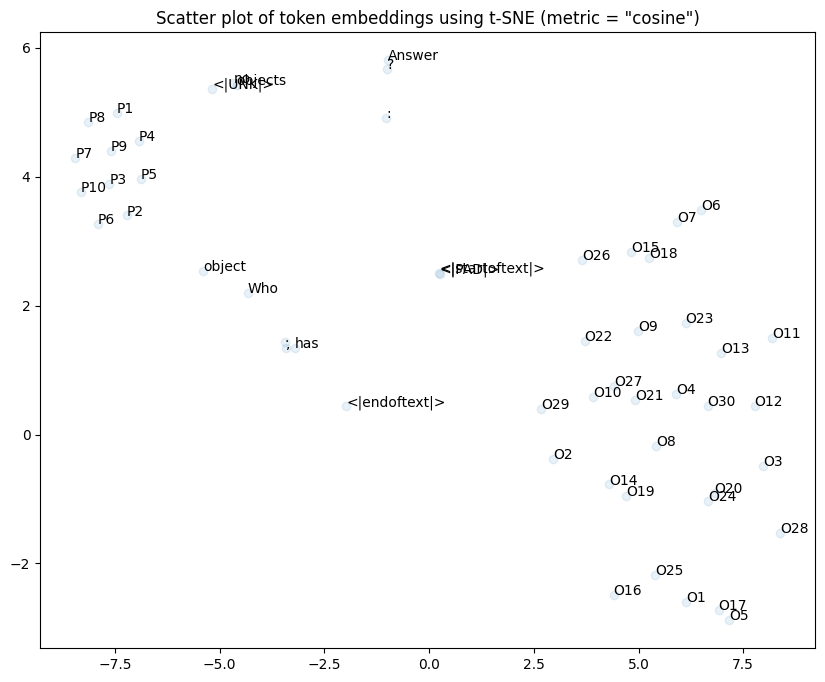

In [151]:
import matplotlib.pyplot as plt

# Set figsize
fig, ax = plt.subplots(figsize=(10,8))
# Scatter points, set alpha low to make points translucent
ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.1)

for i, txt in enumerate(tokenNamesList):
    ax.text(embeddingsdf.iloc[i]['x'], embeddingsdf.iloc[i]['y'], txt)


plt.title('Scatter plot of token embeddings using t-SNE (metric = "cosine")')
plt.show()




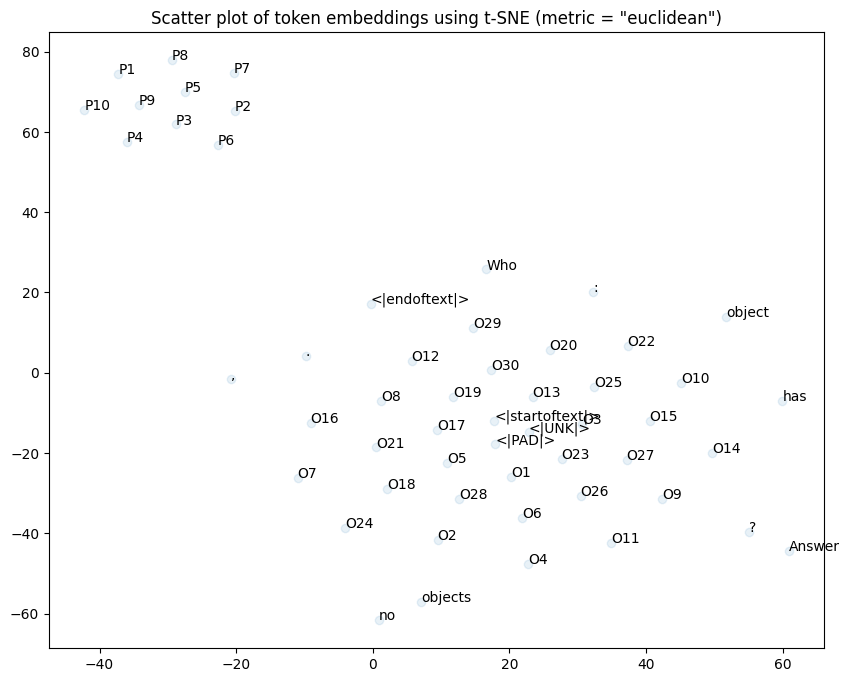

In [155]:
import matplotlib.pyplot as plt

# Set figsize
fig, ax = plt.subplots(figsize=(10,8))
# Scatter points, set alpha low to make points translucent
ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.1)

for i, txt in enumerate(tokenNamesList):
    ax.text(embeddingsdf.iloc[i]['x'], embeddingsdf.iloc[i]['y'], txt)


plt.title('Scatter plot of token embeddings using t-SNE (metric = "euclidean")')
plt.show()




In [21]:
output.logits[0,-3]

tensor([-1.4677e-11, -3.9322e-06,  1.9573e-05,  1.5298e-11,  1.0048e+00,
        -1.2279e-05, -2.2601e-04, -3.7266e-06, -3.1380e-05,  4.2381e-05,
         1.6576e-05, -1.5488e-05, -3.9349e-05,  5.0803e-06, -1.9777e-04,
        -1.4713e-04, -2.2572e-04, -2.1462e-04, -2.1793e-04, -2.0855e-04,
        -1.6139e-04, -3.2466e-04, -1.7203e-04, -2.9251e-04, -7.5277e-05,
         2.9414e-05, -9.7893e-05, -1.0382e-04, -6.7502e-05, -8.9449e-05,
        -1.2322e-04, -4.1108e-05, -9.7762e-05, -1.5313e-04, -1.1356e-04,
        -2.2732e-05, -1.3072e-04, -7.2400e-05, -6.1446e-05, -9.8290e-05,
        -9.6772e-05, -5.3377e-05, -6.1058e-05, -1.1434e-05, -1.3150e-04,
        -8.8219e-05, -7.6494e-05, -8.6504e-05, -6.9138e-05, -1.1558e-04,
        -7.8851e-05, -2.0280e-05,  1.0401e-05, -9.0724e-05])

In [ ]:
model_view(output.attentions, tokens)

In [16]:
# text = "P3 has O1, O8, O19. P2 has no objects. Who has object O19? Answer: P3."
text = "P3 has O1, O8, O19. P2 has no objects. Who has object O7? Answer: P2."


text = tokenizer.bos_token + ' ' + text
tokenized_data = tokenizer(text)

tokens = tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"])

output = model(torch.tensor(tokenized_data["input_ids"]).unsqueeze(0))
head_view(output.attentions, tokens)

pred = output.logits[0,-3].argmax().item()
print("prediction:", tokenizer.convert_ids_to_tokens(pred))

<IPython.core.display.Javascript object>

prediction: P3


In [ ]:
text = "P10 has O2. P1 has O23, O14. P3 has no objects. Who has object O14? Answer: P1."

text = tokenizer.bos_token + ' ' + text
tokenized_data = tokenizer(text)

tokens = tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"])

output = model(torch.tensor(tokenized_data["input_ids"]).unsqueeze(0))
head_view(output.attentions, tokens)

pred = output.logits[0,-3].argmax().item()
print("prediction:", tokenizer.convert_ids_to_tokens(pred))


<IPython.core.display.Javascript object>

prediction: P1


In [ ]:
text = "P3 has O12, O28. P6 has O19, O24, O21. Who has object O28? Answer: P3."

text = tokenizer.bos_token + ' ' + text
tokenized_data = tokenizer(text)

tokens = tokenizer.convert_ids_to_tokens(tokenized_data["input_ids"])

output = model(torch.tensor(tokenized_data["input_ids"]).unsqueeze(0))
head_view(output.attentions, tokens)

pred = output.logits[0,-3].argmax().item()
print("prediction:", tokenizer.convert_ids_to_tokens(pred))

<IPython.core.display.Javascript object>

prediction: P3
